In [16]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in Oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.d2d.fuel_cost = 0.25 #euro/km
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 1000
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

# About number of passengers and drivers for paper experiments

##### each uber dirver works ~1500 min per week = 1500/60/7 hours ~ 4 hours. So we set hour simtime to 4h
##### 25% of trips based on (Amsterdam_requests_new) take place in 4h (08:00-12:00), total number of taxi trips is 22000 per day but 2/3 of this number is uber rides so there is 15000 uber rides per day. 25% of 15000 is 3500 rides.

In [5]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.proportional_std = 0.1 # proportional standard deviation [0.1, 0.2, 0.3] for both VoT & RW distributions
params.d2d.ini_att = 0.01
params.d2d.B_income = 1

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in Oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro 
params.platforms.fare = float(1.2)# float(1.20) #euro/km #http://taxihowmuch.com/
params.platforms.min_fare = float(4) # euro #http://taxihowmuch.com/
params.d2d.fuel_cost = 0.25 #euro/km #https://help.ubercarshare.com/hc/en-gb/articles/360022882131-Choosing-your-car-s-distance-rate  
params.platforms.comm_rate = float(0.20) # float(0.20) for baseline
params.platforms.discount = float(0.0) 
params.platforms.daily_marketing = False
params.platforms.incentive = float(0.0)

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.70
params.d2d.B_WOM = 0.20
params.d2d.B_Marketing = 0.10
params.d2d.diffusion_speed = 10/100 
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.f_stop_crit = False
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 2000
params.nV = 200
params.nD = 500 #7.5 years (July2012-Dec2019) * 12 months * 4 weeks = 360 weeks (days of simulation)
params.simTime = 4 
params.d2d.res_wage = params.simTime*11.16 #10.63 euro #https://www.government.nl/topics/minimum-wage/amount-of-the-hourly-minimum-wage

In [6]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out, f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
27-05-24 10:23:57-WARNING-Setting up 4h simulation at 2024-05-27 08:23:28 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
Day =  0
27-05-24 10:24:04-WARNING-simulation time 2.4 s
nP =  0    nV =  0
Day =  1
27-05-24 10:24:13-WARNING-simulation time 2.8 s
nP =  15    nV =  2
Day =  2
27-05-24 10:24:24-WARNING-simulation time 3.8 s
nP =  41    nV =  5
Day =  3
27-05-24 10:24:35-WARNING-simulation time 4.8 s
nP =  68    nV =  6
Day =  4
27-05-24 10:24:48-WARNING-simulation time 5.0 s
nP =  67    nV =  10
Day =  5
27-05-24 10:25:00-WARNING-simulation time 4.7 s
nP =  69    nV =  7
Day =  6
27-05-24 10:25:16-WARNING-simulation time 5.8 s
nP =  92    nV =  16
Day =  7
27-05-24 10:25:27-WARNING-simulation time 5.0 s
nP =  128    nV =  6
Day =  8
27-05-24 10:25:40-WARNING-simulation time 6.7 s
nP =  137    nV =  16
Day =  9
27-05-24 10:25:53-WARNING-simulation time 5.3 s
nP =  123    nV =  15
Day =  10
27-05-24 10:26:04-WARNING-simulation time 

In [11]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    df_d.at[d, 'EXPERIENCE_U'] = pax_exp.EXPERIENCE_U.mean()
    df_d.at[d, 'WOM_U'] = pax_exp.WOM_U.mean()
    df_d.at[d, 'MARKETING_U'] = pax_exp.MARKETING_U.mean()
    df_d.at[d, 'OUT'] = pax_exp.OUT.value_counts().get(False, 0)
    df_d.at[d, 'plat_revenue'] = pax_exp.plat_revenue.sum()
    
    veh_exp = sim.res[d].veh_exp
    df_s.at[d, 'EXPERIENCE_U'] = veh_exp.EXPERIENCE_U.mean()
    df_s.at[d, 'WOM_U'] = veh_exp.WOM_U.mean()
    df_s.at[d, 'MARKETING_U'] = veh_exp.MARKETING_U.mean()
    df_s.at[d, 'OUT'] = veh_exp.OUT.value_counts().get(False, 0)
    
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT', 'plat_revenue']]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()
        
run_id = 'comm_0.2_fare_1.2'
df_d.to_csv('competition_csv/demand_{}.csv'.format(run_id))
df_s.to_csv('competition_csv/supply_{}.csv'.format(run_id))

<AxesSubplot:ylabel='plat_revenue'>

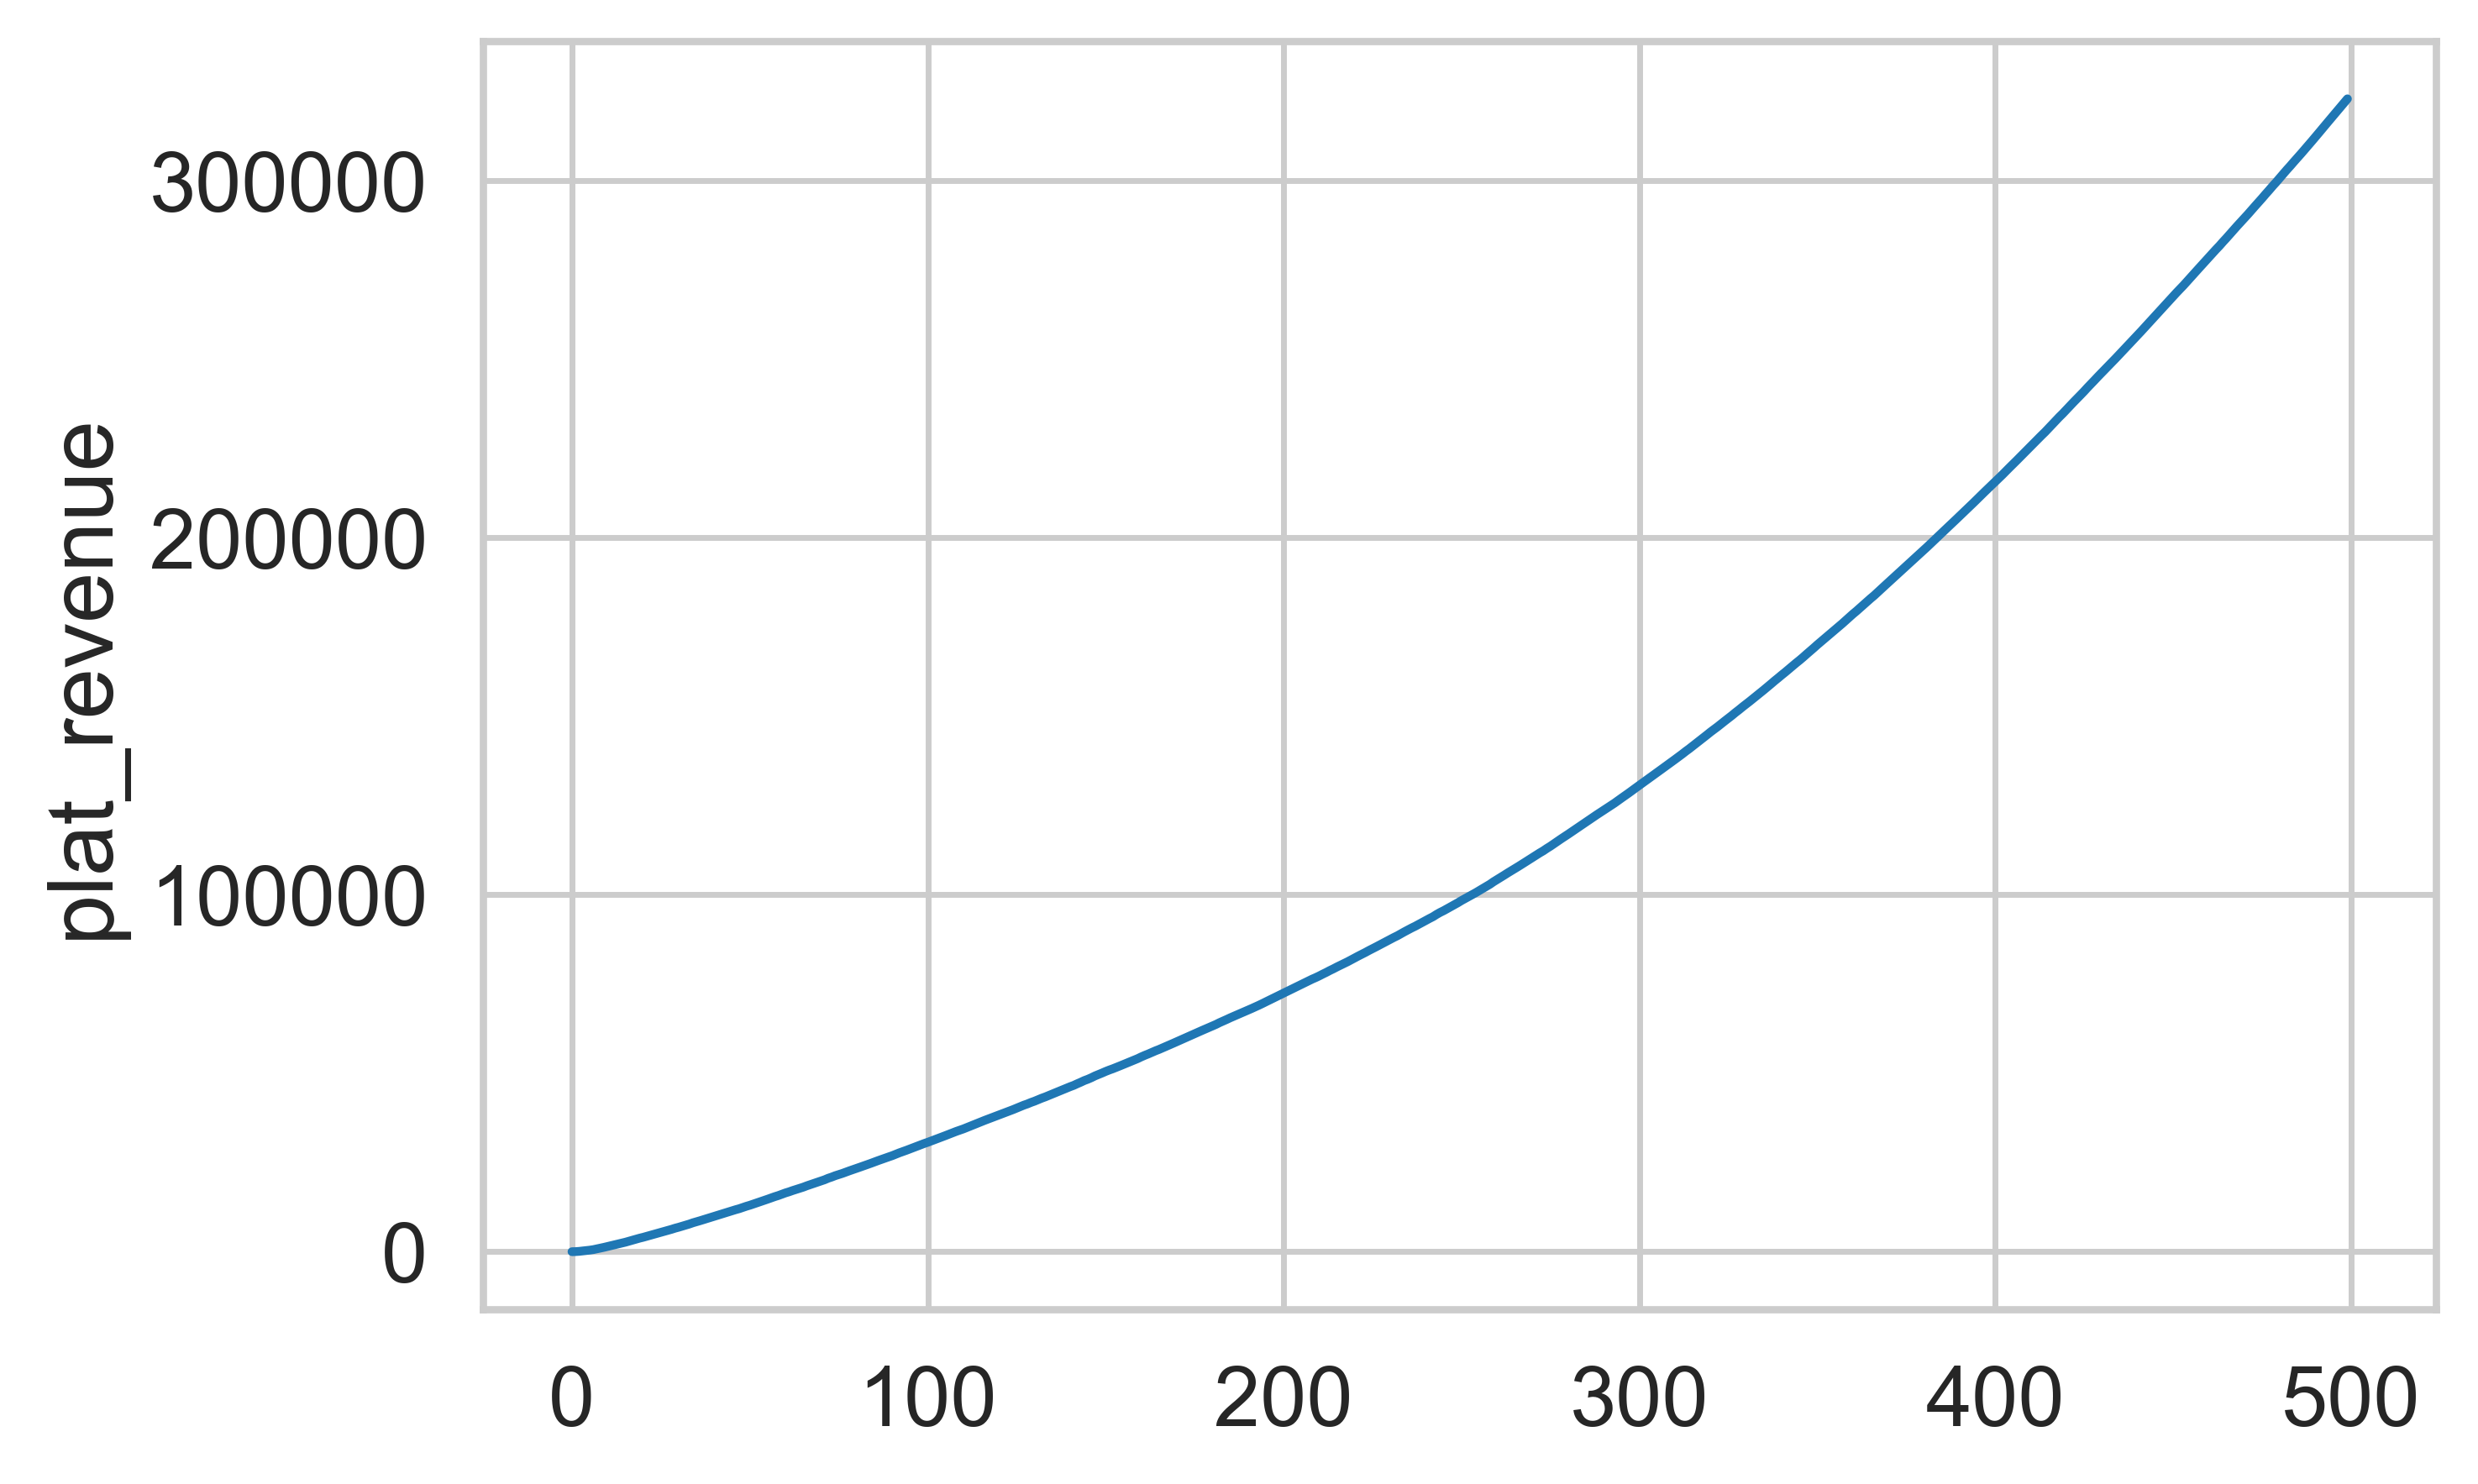

In [15]:
sns.lineplot(x=df_d.index, y=df_d.plat_revenue.cumsum())

In [7]:
def smooth(y,w=41,o=1,d=5):
    from scipy.signal import savgol_filter
    nans = [float('nan') for i in range(0,d)] 
    y = nans + list(savgol_filter(y[d:],w,o))
    for i in range(0,len(y)):
        if y[i]<0:
            y[i] = 0
    return y

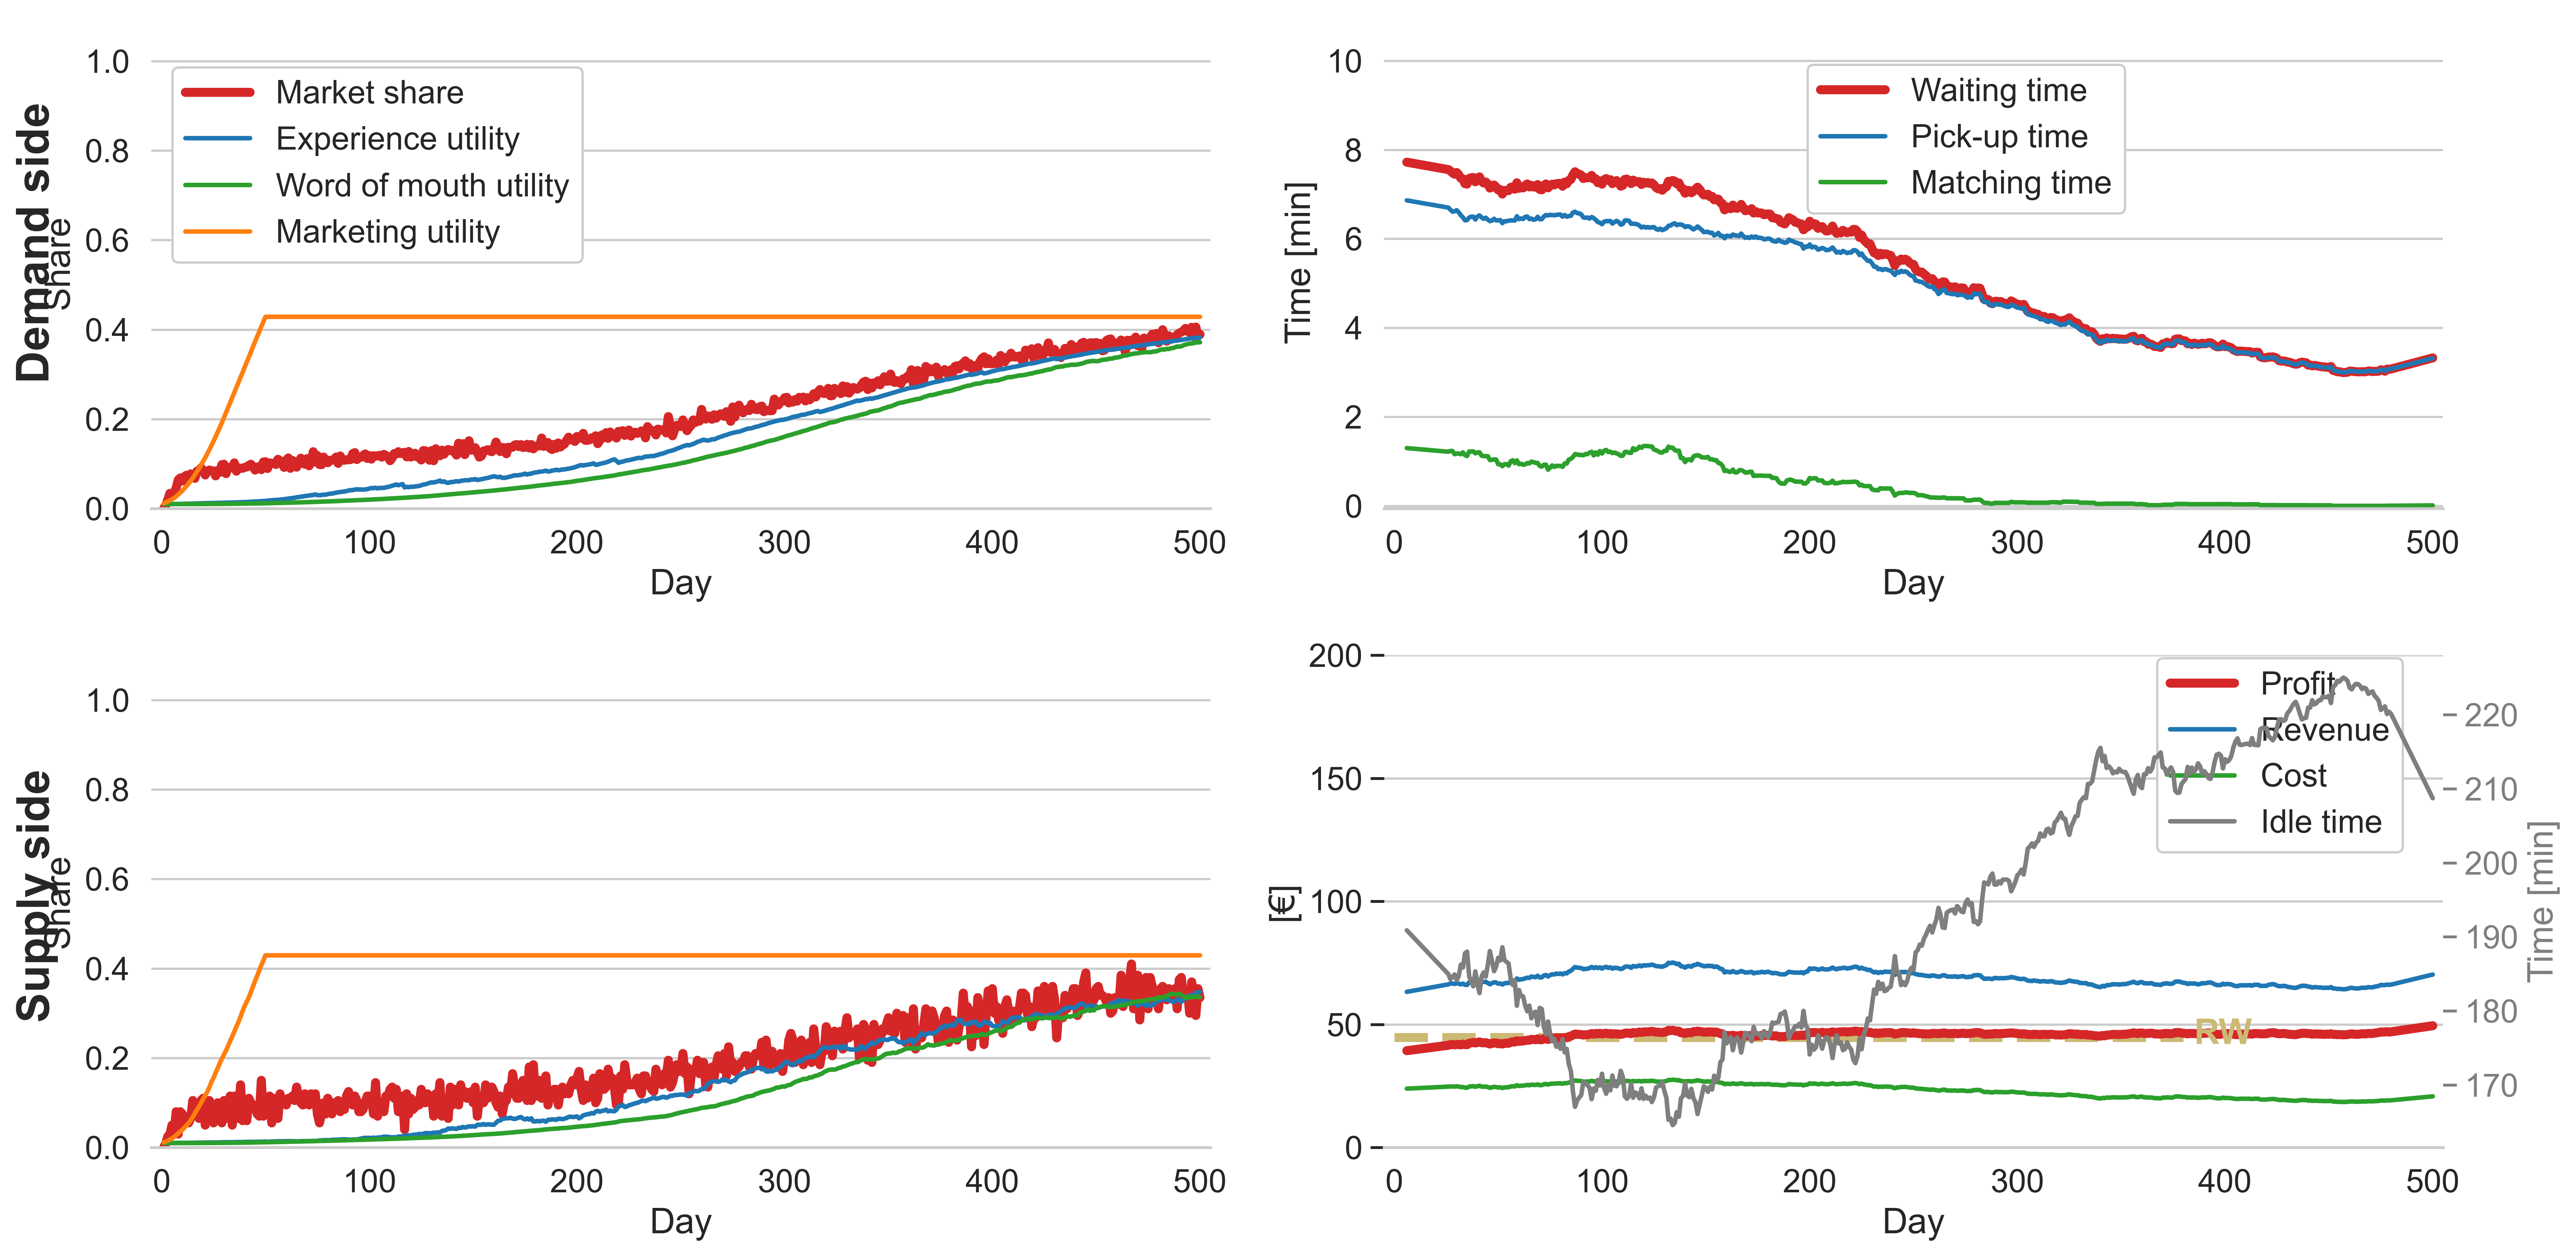

In [8]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
d1 = pd.DataFrame()


for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
        d1['P_WOM_U'] = yw; d1['P_MARKETING_U'] = ym
        d1['P_EXPERIENCE_U'] = ye; d1['P_SHARE'] = yms
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        d1['V_WOM_U'] = yw; d1['V_MARKETING_U'] = ym
        d1['V_EXPERIENCE_U'] = ye; d1['V_SHARE'] = yms
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n][0])
   
    # ax[ax_n][0].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n][0].grid(axis='x')
    ax[ax_n][0].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,sim.params.nD+5))
    
# ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.02,0.5))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1][0].get_legend().set_visible(False)

#===============================================================================================

x = []; yw = []; yp = []; yi = []; ym = []; yr = []; yprof = []; yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())

yw = smooth(yw); ym = smooth(ym); yp = smooth(yp); yi = smooth(yi)
yr = smooth(yr); yprof = smooth(yprof); yc = smooth(yc)

d2 = pd.DataFrame()
d2['yw'] = yw; d2['ym'] = ym; d2['yp'] = yp; d2['yi'] = yi
d2['yr'] = yr; d2['yprof'] = yprof; d2['yc'] = yc

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1][1])#, marker='o')ax.twinx()
ax11 = ax[1][1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1][1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i][1].grid(axis='x')

# ax[0][1].vlines([100], 0, 11, linestyles='dashed', colors='black')
# ax[1][1].vlines([100], 0, 110, linestyles='dashed', colors='black')
ax[1][1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1][1].annotate('RW', xy =(385,42), fontweight='bold', color='y')
  
    
ax[0][1].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,sim.params.nD+5)); ax[1][1].set(xlabel='Day', ylabel='[€]', ylim=(0,200),xlim=(-5,sim.params.nD+5))
ax[0][1].legend(loc=(0.4,0.6),framealpha=1)

ax[0][0].text(x=-70 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-70 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)
sns.despine(left=True)


plt.tight_layout()
# plt.savefig('Fig1x.png')

In [ ]:
--------------------------------------------------------------------------------------

In [9]:
df_demand = pd.DataFrame()
df_supply = pd.DataFrame()

nD=400
demand1 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_demand1.csv')
supply1 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_supply1.csv')
demand1['rep_num'] = 1
demand1['x_data'] = lx = [i for i in range(0,nD-1)]
supply1['rep_num'] = 1
supply1['x_data'] = lx = [i for i in range(0,nD-1)]


demand2 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_demand2.csv')
supply2 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_supply2.csv')
demand2['rep_num'] = 2
demand2['x_data'] = lx = [i for i in range(0,nD-1)]
supply2['rep_num'] = 2
supply2['x_data'] = lx = [i for i in range(0,nD-1)]

demand3 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_demand3.csv')
supply3 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_supply3.csv')
demand3['rep_num'] = 3
demand3['x_data'] = lx = [i for i in range(0,nD-1)]
supply3['rep_num'] = 3
supply3['x_data'] = lx = [i for i in range(0,nD-1)]

demand4 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_demand4.csv')
supply4 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_supply4.csv')
demand4['rep_num'] = 4
demand4['x_data'] = lx = [i for i in range(0,nD-1)]
supply4['rep_num'] = 4
supply4['x_data'] = lx = [i for i in range(0,nD-1)]

demand5 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_demand5.csv')
supply5 = pd.read_csv('AAMAS-2024/csv_results_with_notebook/400_days_supply5.csv')
demand5['rep_num'] = 5
demand5['x_data'] = lx = [i for i in range(0,nD-1)]
supply5['rep_num'] = 5
supply5['x_data'] = lx = [i for i in range(0,nD-1)]

df_demand = pd.concat([df_demand,demand1[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_demand = pd.concat([df_demand,demand2[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_demand = pd.concat([df_demand,demand3[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_demand = pd.concat([df_demand,demand4[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_demand = pd.concat([df_demand,demand5[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])

df_supply = pd.concat([df_supply,supply1[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_supply = pd.concat([df_supply,supply2[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_supply = pd.concat([df_supply,supply3[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_supply = pd.concat([df_supply,supply4[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])
df_supply = pd.concat([df_supply,supply5[['x_data','rep_num', 'EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]])

df_demand['OUT'] = df_demand['OUT']/2000
df_supply['OUT'] = df_supply['OUT']/200

df_demand

x_data  rep_num  EXPERIENCE_U     WOM_U  MARKETING_U     OUT
0         0        1      0.010000  0.010000     0.010000  0.0000
1         1        1      0.010000  0.010000     0.010000  0.0000
2         2        1      0.010000  0.010000     0.010000  0.0000
3         3        1      0.010000  0.010000     0.010000  0.0000
4         4        1      0.010000  0.010000     0.010000  0.0000
..      ...      ...           ...       ...          ...     ...
394     394        5      0.040942  0.128600     0.428473  0.1190
395     395        5      0.041169  0.127239     0.428473  0.1115
396     396        5      0.040788  0.126101     0.428473  0.1190
397     397        5      0.039456  0.124543     0.428473  0.1100
398     398        5      0.040233  0.123561     0.428473  0.1095

[1995 rows x 6 columns]

In [ ]:
0.0000148

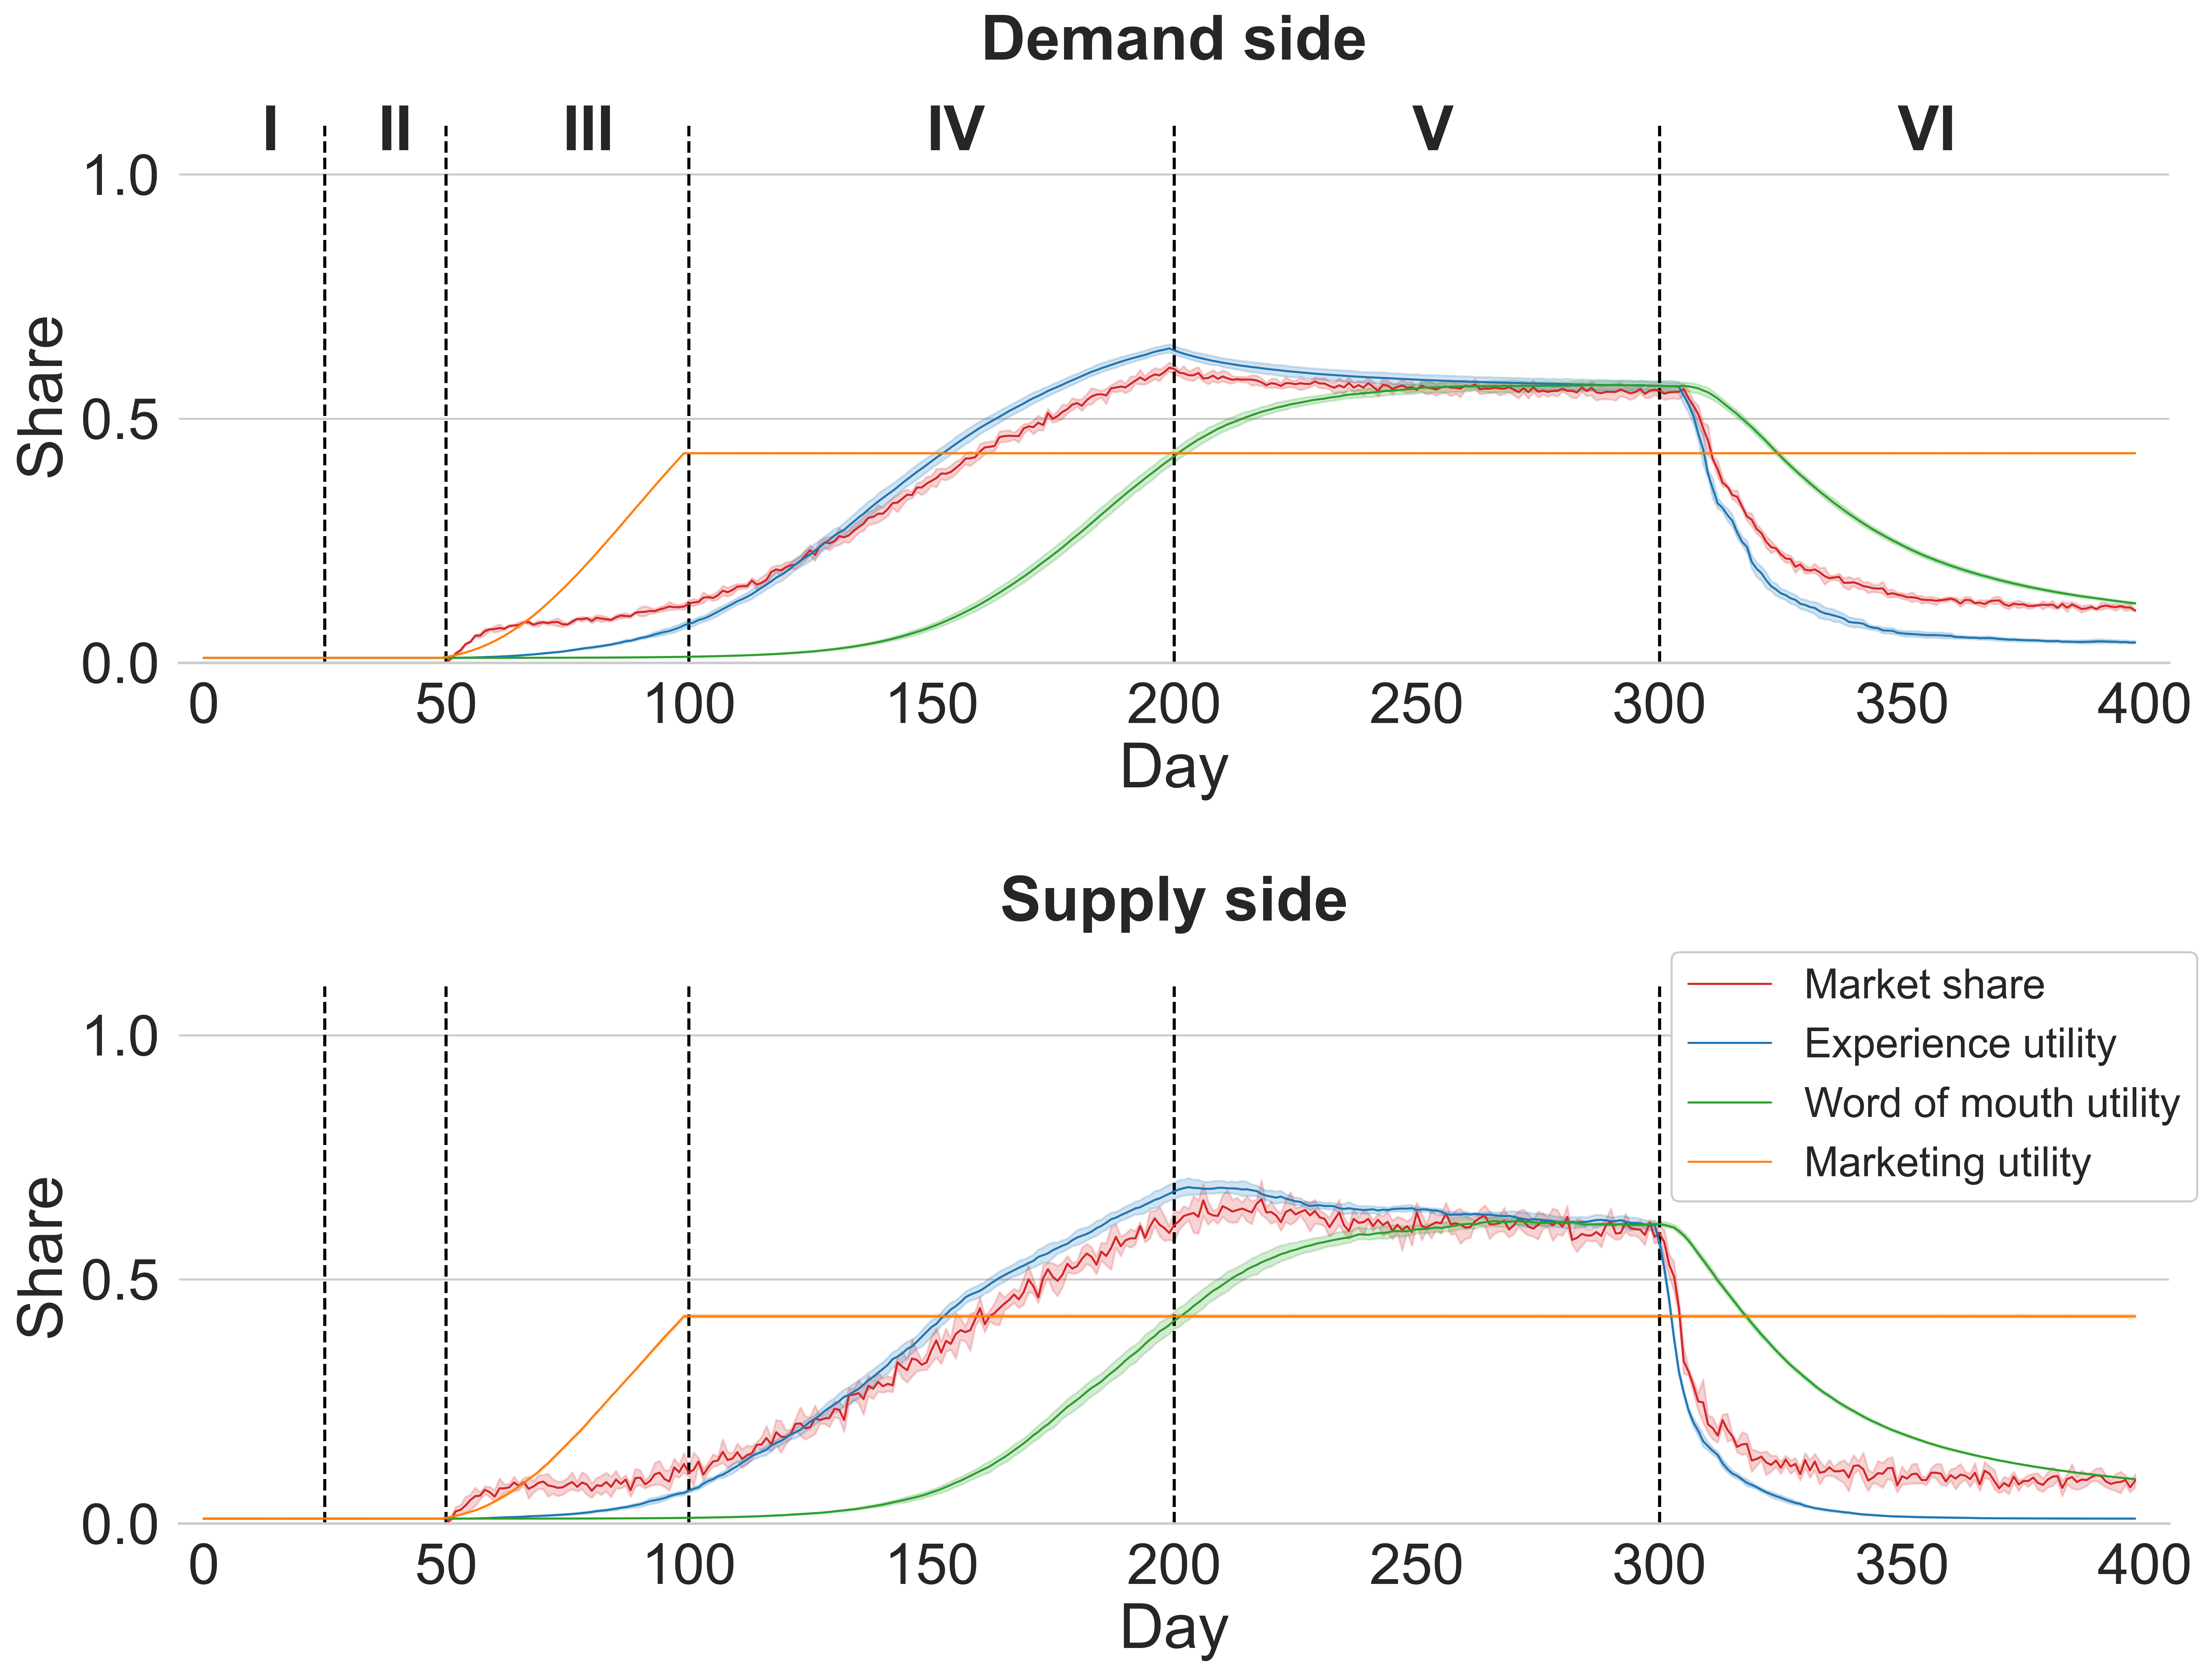

In [61]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=2.5)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
sns.despine(left=True)

nD = 400
nP = 2000
nV = 200
data = [df_demand, df_supply]

for ax_n in [0,1]:
    if ax_n==0:
        n=nP
    else:
        n=nV
    sns.lineplot(data=data[ax_n], x='x_data', y='OUT', label = 'Market share', color='C3', lw=1, ax=ax[ax_n])#, marker='o')
    sns.lineplot(data=data[ax_n], x='x_data', y='EXPERIENCE_U', label = 'Experience utility', color='C0', lw=1, ax=ax[ax_n])#, marker='o')
    sns.lineplot(data=data[ax_n], x='x_data', y='WOM_U', label = 'Word of mouth utility', color='C2', lw=1, ax=ax[ax_n])#, marker='o')
    sns.lineplot(data=data[ax_n], x='x_data', y='MARKETING_U', label = 'Marketing utility', color='C1', lw=1, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center', x=0.5, y=1.1);ax[1].set_title('Supply side',fontweight='bold', loc='center', x=0.5, y=1.1)
ax[1].legend(frameon=True,framealpha=1, loc=(0.75,0.6), fontsize=20)#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
plt.savefig('Fig_aamas1.png')

In [ ]:
---------------------------------------------------------------------------

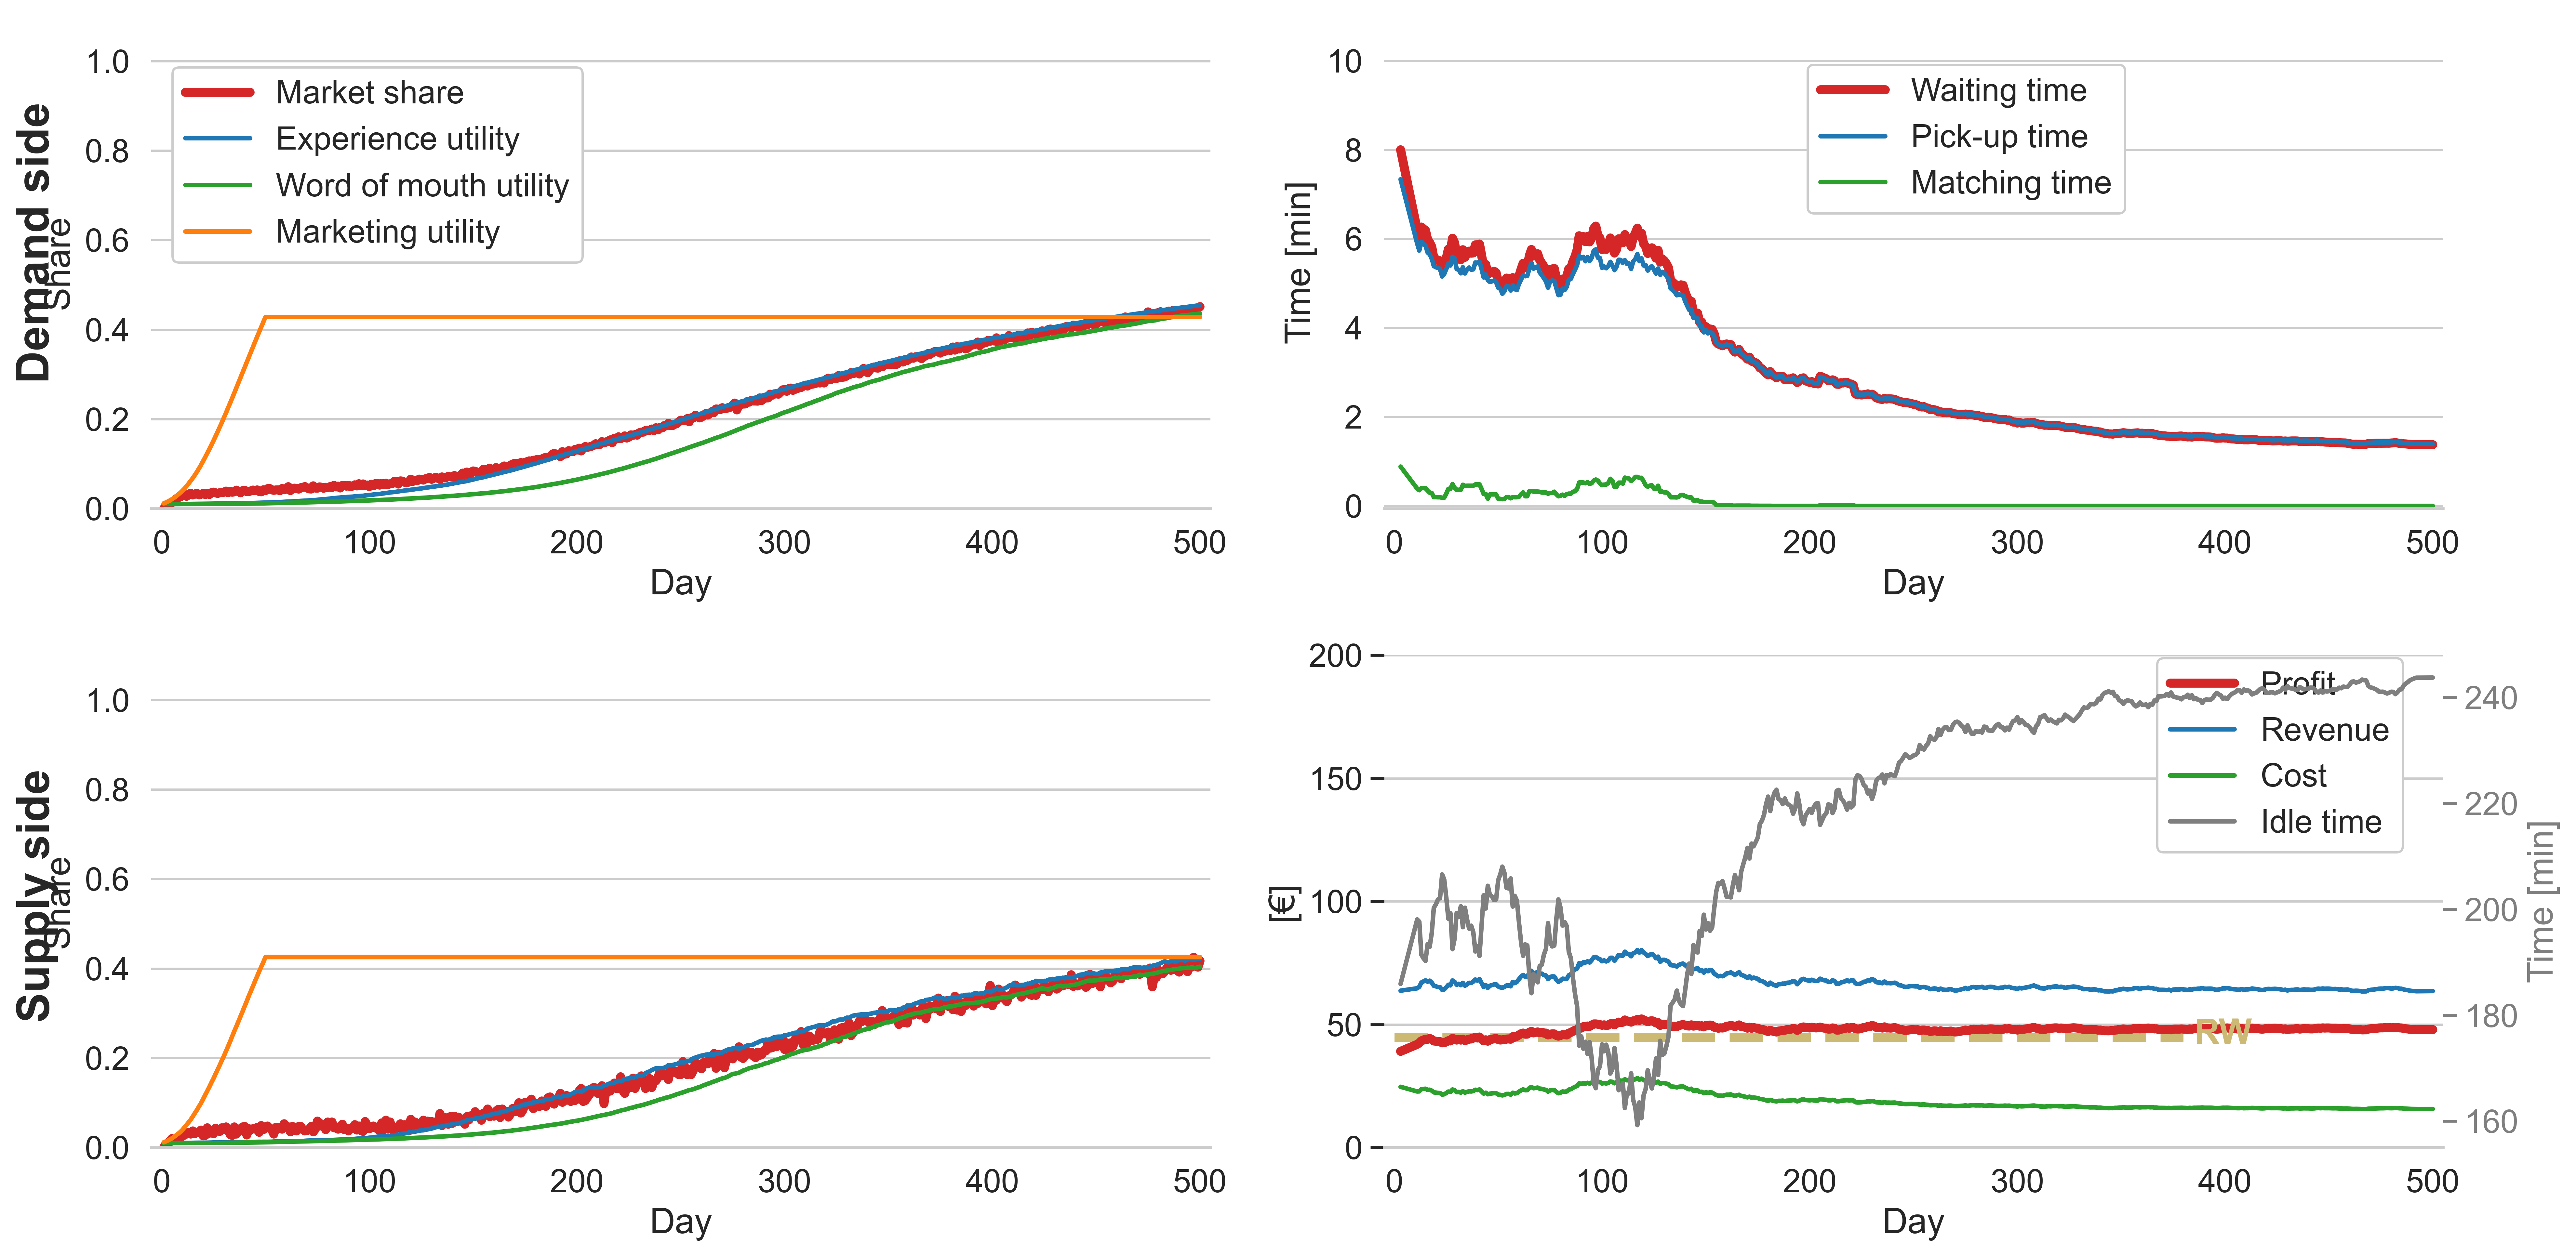

In [ ]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.3)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
d1 = pd.DataFrame()


for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
        d1['P_WOM_U'] = yw; d1['P_MARKETING_U'] = ym
        d1['P_EXPERIENCE_U'] = ye; d1['P_SHARE'] = yms
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        d1['V_WOM_U'] = yw; d1['V_MARKETING_U'] = ym
        d1['V_EXPERIENCE_U'] = ye; d1['V_SHARE'] = yms
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n][0])
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n][0])
   
    # ax[ax_n][0].vlines([100], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n][0].grid(axis='x')
    ax[ax_n][0].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,sim.params.nD+5))
    
# ax[0][0].set_title('Demand side',fontweight='bold', loc='center',fontsize=20);ax[0][1].set_title('Supply side',fontweight='bold', loc='center',fontsize=20)
ax[0][0].legend(frameon=True,framealpha=1, loc=(0.02,0.5))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1][0].get_legend().set_visible(False)

#===============================================================================================

x = []; yw = []; yp = []; yi = []; ym = []; yr = []; yprof = []; yc = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    yw.append(df[df.OUT==False].ACTUAL_WT.mean()) # Waiting time per passenger
    ym.append(df[df.OUT==False].MATCHING_T.mean()) # Matching time per passenger
    # yprof.append(df.plat_profit.sum())
    
    df = sim.res[d].veh_exp
    yp.append(df[df.OUT==False].ARRIVES_AT_PICKUP.mean()/(df[df.OUT==False].nRIDES.mean()*60))
    yi.append(df[df.OUT==False].IDLE_TIME.mean()/60)
    yr.append(df[df.OUT==False].REVENUE.mean())
    yprof.append(df[df.OUT==False].ACTUAL_INC.mean())
    yc.append(df[df.OUT==False].COST.mean())

yw = smooth(yw); ym = smooth(ym); yp = smooth(yp); yi = smooth(yi)
yr = smooth(yr); yprof = smooth(yprof); yc = smooth(yc)

d2 = pd.DataFrame()
d2['yw'] = yw; d2['ym'] = ym; d2['yp'] = yp; d2['yi'] = yi
d2['yr'] = yr; d2['yprof'] = yprof; d2['yc'] = yc

x = [i for i in range(1,len(yp)+1)]
sns.lineplot(x=x, y=yw, label = 'Waiting time', color='C3',lw=4, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yp, label = 'Pick-up time', color='C0',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=ym, label = 'Matching time', color='C2',lw=2, ax=ax[0][1])#, marker='o')
sns.lineplot(x=x, y=yprof, label = 'Profit', color='C3',lw=4, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yr, label = 'Revenue', color='C0',lw=2, ax=ax[1][1])#, marker='o')
sns.lineplot(x=x, y=yc, label = 'Cost', color='C2',lw=2, ax=ax[1][1])#, marker='o')ax.twinx()
ax11 = ax[1][1].twinx()
sns.lineplot(x=x, y=yi, label = 'Idle time', color='C7',lw=2, ax=ax11)#, marker='o')
ax11.set(ylabel='Time [min]')
ax11.grid(b=None)

lines, labels = ax[1][1].get_legend_handles_labels()
lines2, labels2 = ax11.get_legend_handles_labels()
ax[1][1].legend(lines + lines2, labels + labels2,framealpha=1, loc=(0.73,0.6))
ax11.legend().remove()
# ax11.spines['right'].set_color('C7')
ax11.tick_params(axis='y', colors='C7')
ax11.yaxis.label.set_color('C7')

for i in [0,1]:
    ax[i][1].grid(axis='x')

# ax[0][1].vlines([100], 0, 11, linestyles='dashed', colors='black')
# ax[1][1].vlines([100], 0, 110, linestyles='dashed', colors='black')
ax[1][1].hlines([params.d2d.res_wage], 0, 380, linestyles='dashed', colors='y', lw=4)
ax[1][1].annotate('RW', xy =(385,42), fontweight='bold', color='y')
  
    
ax[0][1].set(xlabel='Day', ylabel='Time [min]', ylim=(-0.06,11), xlim=(-5,sim.params.nD+5)); ax[1][1].set(xlabel='Day', ylabel='[€]', ylim=(0,200),xlim=(-5,sim.params.nD+5))
ax[0][1].legend(loc=(0.4,0.6),framealpha=1)

ax[0][0].text(x=-70 ,y=0.3, s='Demand side',fontweight='bold',fontsize=20, rotation=90)
ax[1][0].text(x=-70 ,y=0.3, s='Supply side',fontweight='bold',fontsize=20, rotation=90)
sns.despine(left=True)


plt.tight_layout()
# plt.savefig('Fig1x.png')